
Running with FG-ERK integrator: Bogacki-Shampine-ERK (order = 3)
FG time elapsed: 0.0391045 s
FG nsteps:       20  

Running with TT-ERK integrator: Bogacki-Shampine-ERK (order = 3)
TT time elapsed: 0.0961369 s 
TT nsteps:       20  


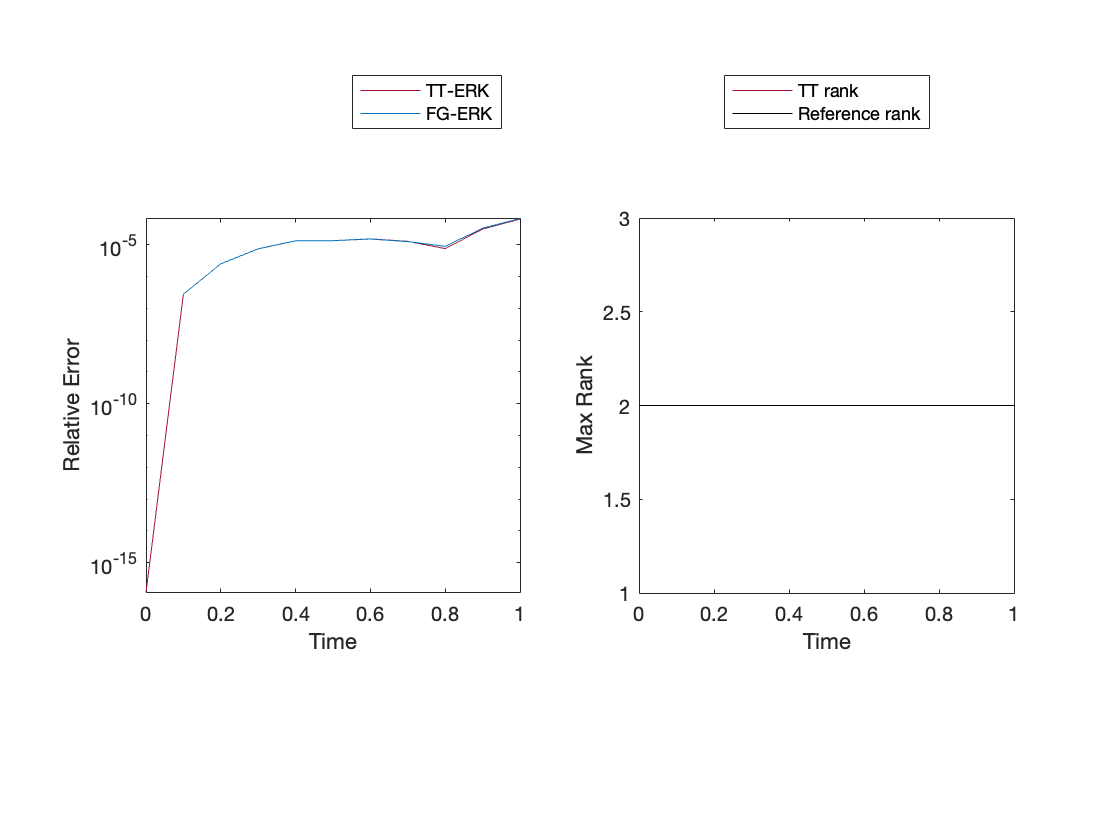

In [1]:
addpath(genpath('../../matlab/RK-1/'))
addpath(genpath('../../matlab/utils/tt-toolbox/'))
close all; clear;


% Test problem:     $u' = -2t(x+y)u, \quad t \in [0,1], \quad (x,y) \in [0,1] 
% \times [0,1]$  constant in space 
% 
% Exact solution :  $u(t) = \sin(\pi(x+y))\exp(-t^2(x+y)$
% 
% 
clear, close all
format long e

%if ~contains(path, '/TT-Toolbox-master')
%    error('Please make sure TT-Toolbox in path \n');
%end 

N = 100;                                      % number of points in space
%% Space Setup
axx = [0,1]; axy = axx;                       % x and y solution intervals
xp = linspace(axx(1),axx(2),N); yp = xp;      % points in space
[X,Y] = meshgrid(xp,yp);                      % 2D grid points 
Gx = {xp;ones(size(xp))};  Xtt = cell2core(tt_tensor,Gx);    % X and Y tensors 
Gy = {ones(size(yp));yp};  Ytt = cell2core(tt_tensor,Gy);

%% Time setup, Tolerances, RK method
tspan = [0,1];                                 % time interval 
nt = 11;  % number of time samples to take 
tvals = linspace(tspan(1),tspan(2),nt);       % time samples for solution comparison
% Step sizes 
dtmin = 1e-5;
dtmax = 0.1; 
dtinit = 1e-2;
% Tolerances
rtol = 1e-4;               % relative tolerance for tt RK solver 
atol = 1e-14*tt_ones(N,2); % absolute tolerance for tt/fg RK solver 
atolfg = 1e-14*ones(N);    % absolute tolerance for fg RK solver 
ett = rtol;                % tt-rank truncation tolerance 
% RK method
mname = 'Bogacki-Shampine-ERK';
B = butcher(mname); s = numel(B(1,:))-1;


%% Right-hand side functions, initial conditions, exact solution  
U0 = uexact(X,Y,tvals(1));             % initial condition
U0tt = tt_tensor(U0,1e-12);       % tt initial condition 

fgrhs = @(t,U) fg_oderhs(t,X,Y,U);    % full grid right hand side 
ttrhs = @(t,Utt,tt_tol) tt_oderhs(t,Xtt,Ytt,Utt,tt_tol); % tt right hand side 
% Exact solution
Uexact = cell(1,nt);
Uttexact = cell(1,nt);
refrank = zeros(size(tvals));
for i = 1:nt
Uexact{i} = uexact(X,Y,tvals(i));
Uttexact{i} = tt_tensor(Uexact{i},ett);
refrank(i) = max(Uttexact{i}.r); 
end

%% Full grid ERK solve 
solverparameters = {'B','rtol','dtmin','dtmax','dtinit'};
par = vars2struct(solverparameters{:});
par.atol = atolfg;
fprintf('\nRunning with FG-ERK integrator: %s (order = %i)\n',mname,B(s+1,1))
tstart = tic; 
[~,Ufg,nstepsRK,output] = solve_ERK(fgrhs,tvals,U0,par);
fg_time = toc(tstart);
fprintf('FG time elapsed: %g s\n',fg_time)
fprintf('FG nsteps:       %g  \n',nstepsRK)

% Storage initialization
fgerror = zeros(size(tvals));

for i = 1:nt
    error  = Uexact{i}-Ufg{i};
    fgerror(i) = norm(error,'fro')/norm(Uexact{i},'fro');
end

%% TT ERK solve 
solverparameters = {'B','rtol','atol','dtmin','dtmax','dtinit'};
par = vars2struct(solverparameters{:});
par.ettinit = ett;
fprintf('\nRunning with TT-ERK integrator: %s (order = %i)\n',mname,B(s+1,1))
tstart = tic; 
[~,UttRK,nstepstt,tt_output] = solve_ERKtt(ttrhs,tvals,U0tt,par);
tt_time = toc(tstart);
fprintf('TT time elapsed: %g s \n',tt_time)
fprintf('TT nsteps:       %g  \n',nstepstt)

% Storage initialization
tterror = zeros(size(tvals));
maxranks = tterror;

% Get error and ranks 
for i = 1:nt
    error  = Uttexact{i} - UttRK{i};
    tterror(i) = norm(error)/norm(Uttexact{i});        % relative errror 
    maxranks(i) = max(UttRK{i}.r);
end

%% Plotting
% colors
ttcolor = [0.6350 0.0780 0.1840]; %redish
fgcolor = [0 0.4470 0.7410]; %blueish
refcolor = [0 0 0]; %black

figure 
subplot(1,2,1)
semilogy(tvals,tterror,'color',ttcolor)
hold on
semilogy(tvals,fgerror,'color',fgcolor)
axis square
legend('TT-ERK','FG-ERK','Location','best')
xlabel('Time'), ylabel('Relative Error')
subplot(1,2,2)
plot(tvals,maxranks,'color',ttcolor)
hold on
plot(tvals,refrank,'Color',refcolor)
axis square
legend('TT rank','Reference rank','Location','best')
xlabel('Time'), ylabel('Max Rank')

%% Functions
function dU = fg_oderhs(t,X,Y,U)
dU = -2*t*(X+Y).*U;
end 
function ue = uexact(x,y,t)
ue = sin(pi*(x+y)).*exp(-t^2*(x+y));
end 
function duTT = tt_oderhs(t,Xtt,Ytt,Utt,tt_tol)
duTT = -2*t*(Xtt+Ytt).*Utt;
duTT = round(duTT,tt_tol);               % truncate tt-ranks 
end 
